In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil

from utils import *
from datasets import *
from models import *
from profiler import WingbeatDatasetProfiler

Available workers: 16


# Cleaning Settings

In [3]:
maxpeaks = 15
minpeaks = 1
maxscore = 15
minscore = 2.5
minduration = 100
selection = f"peaks>={minpeaks} & peaks<={maxpeaks} & score>{minscore} & score<={maxscore} & duration>={minduration}"

# Dataset SD

In [51]:
dataset_suzukii_sd = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Suzukii/", bandpass_low=140., bandpass_high=1500., rpiformat=False, custom_label=[0])

Found 2725 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Suzukii/, and 1 label(s): ['from_sd']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


In [52]:
dataset_melanogaster_sd = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/", bandpass_low=140., bandpass_high=1500., rpiformat=False, custom_label=[0])

Found 21129 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/, and 1 label(s): ['from_sd']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Dataset RPi

In [53]:
dataset_suzukii_rpi = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Suzukii/", bandpass_low=140., bandpass_high=1500., rpiformat=True, custom_label=[0])

Found 128 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Suzukii/, and 1 label(s): ['from_rpi']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


In [54]:
dataset_melanogaster_rpi = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster//", bandpass_low=140., bandpass_high=1500., rpiformat=True, custom_label=[0])

Found 436 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster//, and 1 label(s): ['from_rpi']
Label(s) changed to [0]


  warnings.warn('nperseg = {0:d} is greater than input length '
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 5000 is greater than input length  = 4667, using nperseg = 4667
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 5000 is greater than input length  = 4667, using nperseg = 4667
  warnings.warn('nperseg = {0:d} is greater than input length '


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Dataframes

In [68]:
df_melanogaster_rpi = dataset_melanogaster_rpi.df.query(selection)
df_suzukii_rpi = dataset_suzukii_rpi.df.query(selection)
df_melanogaster_rpi = df_melanogaster_rpi.sample(df_suzukii_rpi.shape[0])
print(f"df melanogaster rpi shape:\t {df_melanogaster_rpi.shape}")
print(f"df suzukii rpi shape:\t\t {df_suzukii_rpi.shape}\n")

df_melanogaster_sd = dataset_melanogaster_sd.df.query(selection)
df_suzukii_sd = dataset_suzukii_sd.df.query(selection)
df_melanogaster_sd = df_melanogaster_sd.sample(df_suzukii_sd.shape[0])
print(f"df melanogaster sd shape:\t {df_melanogaster_sd.shape}")
print(f"df suzukii sd shape:\t\t {df_suzukii_sd.shape}")

df melanogaster rpi shape:	 (106, 14)
df suzukii rpi shape:		 (106, 14)

df melanogaster sd shape:	 (1931, 14)
df suzukii sd shape:		 (1931, 14)


# Comparison 
### (for Melanogaster, sd vs rpi)

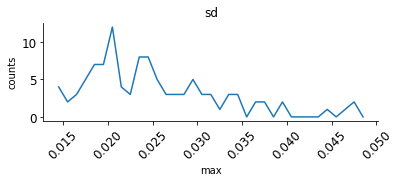

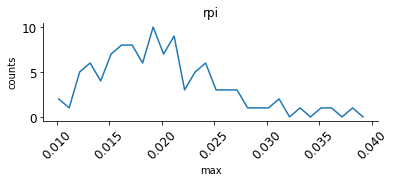

In [74]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_melanogaster_sd.sample(df_melanogaster_rpi.shape[0]), 'max', res=0.001)
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_melanogaster_rpi, 'max', res=0.001)

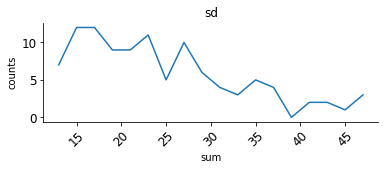

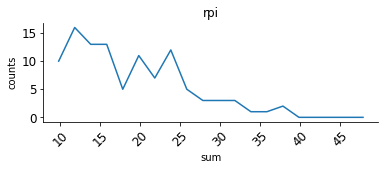

In [76]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_melanogaster_sd.sample(df_melanogaster_rpi.shape[0]), 'sum', res=2, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_melanogaster_rpi, 'sum', res=2)

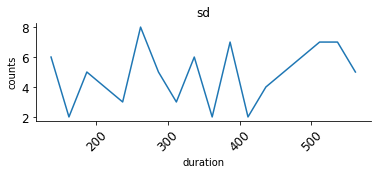

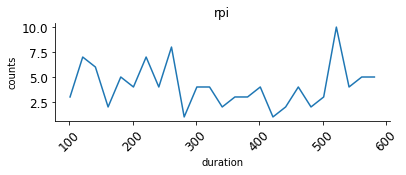

In [77]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_melanogaster_sd.sample(df_melanogaster_rpi.shape[0]), 'duration', res=25, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_melanogaster_rpi, 'duration', res=20)

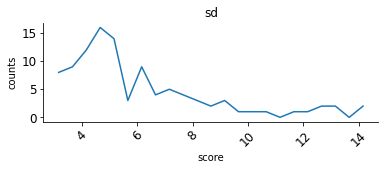

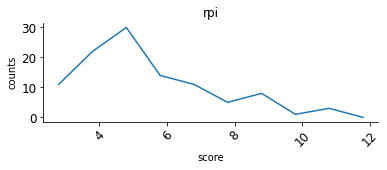

In [78]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_melanogaster_sd.sample(df_melanogaster_rpi.shape[0]), 'score', res=0.5, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_melanogaster_rpi, 'score', res=1)

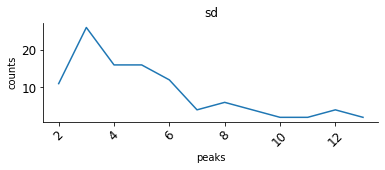

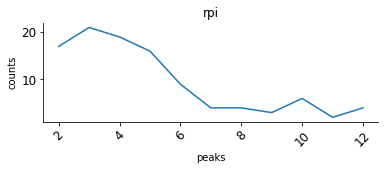

In [79]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_melanogaster_sd.sample(df_melanogaster_rpi.shape[0]), 'peaks', res=1, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_melanogaster_rpi, 'peaks', res=1)

# Bad Chunk Score

## How BCS was made

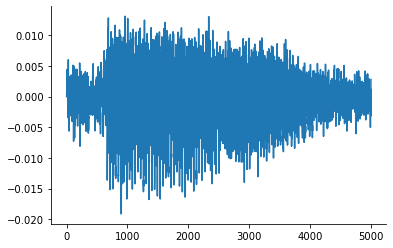

PartA score: 2.4415150292623604
PartB score: 5.710436123766929
PartB score - PartA score : 3.2689210945045684


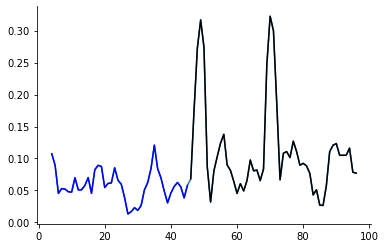

In [80]:
n = np.random.randint(0, len(df_melanogaster_rpi))

open_wingbeat(df_melanogaster_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_melanogaster_rpi.x.iloc[n]).squeeze().numpy()
sig = scale(sig)

part = sig[620:712+5]
part = pd.Series(part).rolling(5).std().abs()
part.plot()

partA = part.iloc[:46]
partB = part.iloc[46:]
# plt.figure()
partA.plot(color='b')
partB.plot(color='k')

scoreA = partA.sum()
scoreB = partB.sum()

score = scoreB - scoreA

print(f"PartA score: {scoreA}\nPartB score: {scoreB}")
print(f"PartB score - PartA score : {score}")

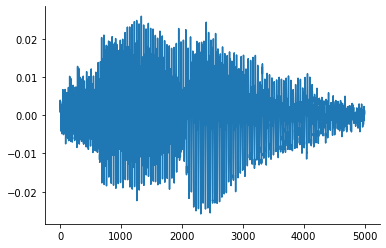

1.5445552867753651

In [85]:
n = np.random.randint(0, len(df_melanogaster_rpi))
open_wingbeat(df_melanogaster_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_melanogaster_rpi.x.iloc[n]).squeeze().numpy()

get_bad_first_chunk_score(sig)

## Examples

 30%|███       | 6/20 [00:00<00:00, 54.71it/s]

26 out of 106


100%|██████████| 20/20 [00:00<00:00, 61.74it/s]


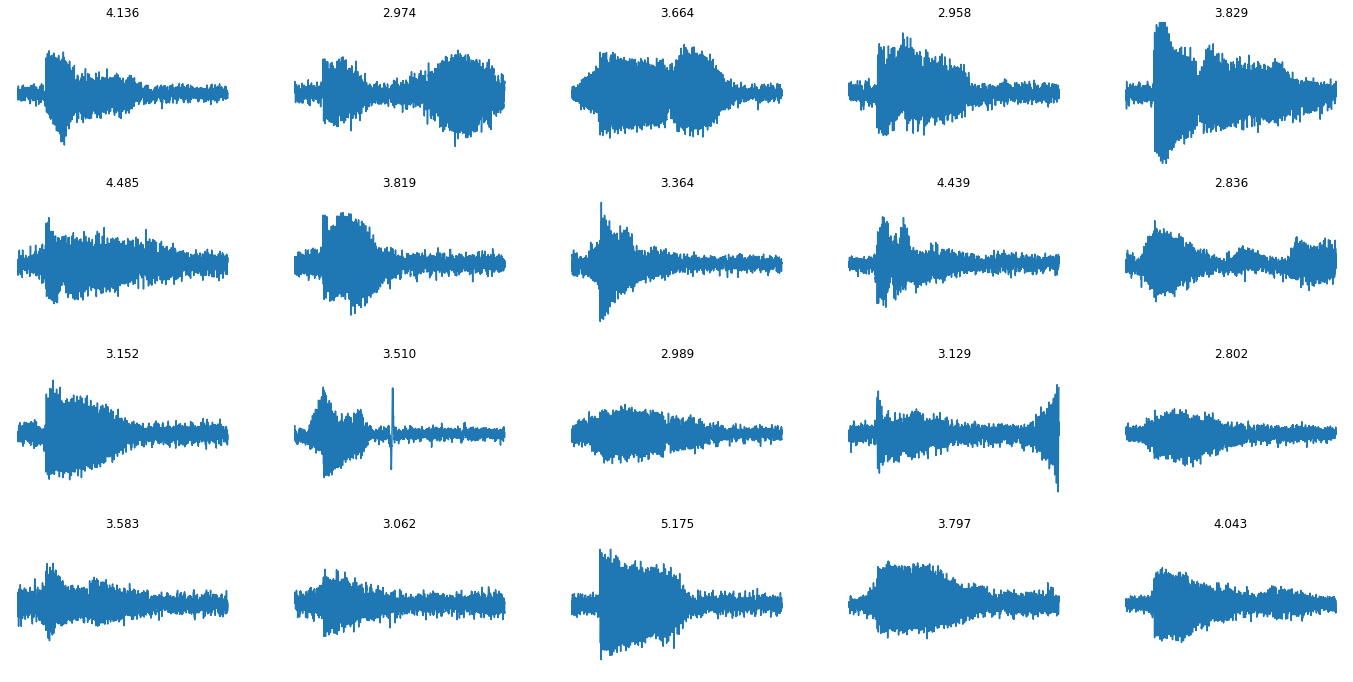

In [89]:
bcs = 2.8

df = df_melanogaster_rpi[df_melanogaster_rpi.badchunkscore>bcs]
print(f"{df.shape[0]} out of {df_melanogaster_rpi.shape[0]}")

plt.figure(figsize=(24,12))
for i in tqdm(range(20)):
    plt.subplot(4,5,i+1)
    plt.plot(open_wingbeat(df.x.iloc[i]).squeeze().numpy())
    plt.ylim(-.03,.03)
    plt.axis('off')
    plt.title(f"{df.badchunkscore.iloc[i]:.3f}")

# Using DrosophilaNet

In [196]:
name = 'drosophilatime' # 'inception' # 'drosophilatime'
outs = 1 # you can set this to 1 if you want to use binary CE loss instead of CrossEntropy
num_epochs = 35
modeltype = f'{name}_outs{outs}_epochs{num_epochs}' #'inception'
pretrained_modelname = f"model_{modeltype}_best"
batch_size = 32
batch_size_val = 32
num_workers = 10
dropout_rate = .2
valsplit_pct = .2 # 0.13
random_seed= 42

model = DrosophilaNetTIME(outputs=outs, dropout_p=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model = load_checkpoint(f"../data_created/{pretrained_modelname}.pth.tar", model, optimizer)[0]
model = model.to('cpu', dtype=torch.float)
model.eval();

In [197]:
from transforms import *
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]

rpi_dataset = DataFrameset(df_melanogaster_rpi, transform=transforms.Compose(transforms_list_test))
rpi_dataloader = DataLoader(rpi_dataset, batch_size=batch_size_val, shuffle=False)

In [203]:
def get_preds(df, model, th=0.5):
    preds = []
    preds_raw = []
    for n in tqdm(range(len(df))):
        sig = open_wingbeat(df.x.iloc[n]).cpu()
        sig = torch.from_numpy(butter_bandpass_filter(sig, 
                                                    lowcut=140,
                                                    highcut=1500,
                                                    fs=8000,
                                                    order=4)).float()        
        out = model(sig.unsqueeze(0))
        preds_raw.append(out.cpu().detach().numpy()[0,0])
        preds.append(int(out >= th))

    df['rawpred'] = preds_raw
    df['preds'] = preds
    
    return df.preds.value_counts()    

In [204]:
get_preds(df_melanogaster_rpi, model)

100%|██████████| 106/106 [00:01<00:00, 60.74it/s]


1    88
0    18
Name: preds, dtype: int64

In [205]:
get_preds(df_suzukii_rpi, model)

100%|██████████| 106/106 [00:01<00:00, 64.15it/s]
<ipython-input-203-d1cf014b4a29>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rawpred'] = preds_raw
<ipython-input-203-d1cf014b4a29>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = preds


1    101
0      5
Name: preds, dtype: int64

In [206]:
get_preds(df_melanogaster_sd, model)

100%|██████████| 1931/1931 [00:29<00:00, 65.77it/s]


0    1118
1     813
Name: preds, dtype: int64

In [207]:
get_preds(df_suzukii_sd, model)

100%|██████████| 1931/1931 [00:29<00:00, 65.62it/s]
<ipython-input-203-d1cf014b4a29>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rawpred'] = preds_raw
<ipython-input-203-d1cf014b4a29>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = preds


1    1871
0      60
Name: preds, dtype: int64

In [208]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')

In [209]:
get_preds(extra_df[extra_df.y==0], model, th=.5)

100%|██████████| 1382/1382 [00:21<00:00, 63.50it/s]
<ipython-input-203-d1cf014b4a29>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rawpred'] = preds_raw
<ipython-input-203-d1cf014b4a29>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = preds


0    1131
1     251
Name: preds, dtype: int64

In [210]:
get_preds(extra_df[extra_df.y==1], model, th=.5)

100%|██████████| 24332/24332 [06:06<00:00, 66.42it/s]
<ipython-input-203-d1cf014b4a29>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rawpred'] = preds_raw
<ipython-input-203-d1cf014b4a29>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = preds


1    23132
0     1200
Name: preds, dtype: int64

# Hist of BCS when wrong

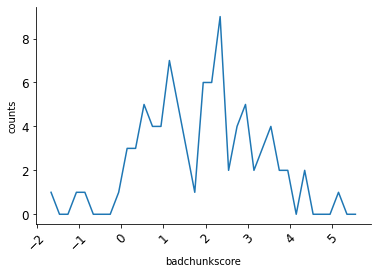

In [211]:
np_hist(df_melanogaster_rpi[df_melanogaster_rpi.preds==1], 'badchunkscore', res=.2)

## Hist of BCS when right

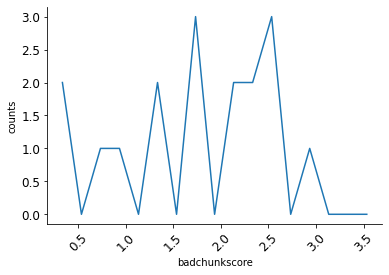

In [212]:
np_hist(df_melanogaster_rpi[df_melanogaster_rpi.preds==0], 'badchunkscore', res=.2)